In [1]:
# toc (adds a table of contents)
from typing import Callable, List, Iterable

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.integrate import odeint

plt.style.use('../maroon_ipynb.mplstyle')  # applies MSU theme to plots

# Problem 1
## Given

$$
\frac{d^2 x}{d t^2}-\mu\left(1-x^2\right) \frac{d x}{d t}+x-A \sin (\omega t)=0
$$

where $\mu=1$, $\omega=\frac{2\pi}{10}$, and $A=10$

## Find
From the differential equation above,

a. Find the state variable form.
b. Use Euler's Explicit method to obtain a numerical solution of the state variable equations from part (a). Assume zero initial conditions and that $t\le20$. Find the smallest value of $\Delta t$ that gives a converged solution (solution doesn't change as time step decreases).
c. Repeat part (b) using a fourth order runge kutta solver with a fixed time step.
d. The results in parts (b) and (c) should be the same, but the value of $\Delta t$ chosen for (c) should be smaller than that for part (b). If the method used in part (c) requires four times the computational resources per time step, compare the computational resources for each case.

## Solution
### Part A

In [2]:
mu_, omega_, A_ = 1, 2*np.pi/10, 10  # constants (units not given)

# Defining the ODE
t, mu, omega, A = sp.symbols('t mu omega A')
x0 = sp.Function('x_0')(t)

eq = sp.Eq(x0.diff(t, 2) - mu*(1 - x0**2)*x0.diff(t) + x0 - A*sp.sin(omega*t), 0)
eq

Eq(-A*sin(omega*t) - mu*(1 - x_0(t)**2)*Derivative(x_0(t), t) + x_0(t) + Derivative(x_0(t), (t, 2)), 0)

This is a just a single second order ODE, so it only requires one state variable to make a system of first order ODEs.

In [3]:
# Define the new state variable
x1 = sp.Function('x_1')(t)

# Add the new state variable as the second equation
eq2 = sp.Eq(x1, x0.diff(t))

# Substitute the second state variable into the original equation
eq1 = eq.subs(x0.diff(t), x1)
display(eq1, eq2)

Eq(-A*sin(omega*t) - mu*(1 - x_0(t)**2)*x_1(t) + x_0(t) + Derivative(x_1(t), t), 0)

Eq(x_1(t), Derivative(x_0(t), t))

In [4]:
# Solve the system of equations
sol = sp.solve([eq1, eq2], [x0.diff(), x1.diff()], dict=True)[0]
for key, value in sol.items():
    display(sp.Eq(key, value))

Eq(Derivative(x_0(t), t), x_1(t))

Eq(Derivative(x_1(t), t), A*sin(omega*t) - mu*x_0(t)**2*x_1(t) + mu*x_1(t) - x_0(t))

As seen above, only first order derivatives are on the left hand side. This is the state variable form, but we can just manually write the python function for numerical use with how simple this is. For more complex problems, you can automate the conversion from `sympy` operations to python or `numpy` operations by using the `lambdify` function.

In [5]:
# Defining state variable function
def state_vars(x, t_):
    return [
        x[1],
        A_*np.sin(omega_*t_) - mu_*x[0]**2*x[1] + mu_*x[1] - x[0]
    ]

### Part B
The below code cell is the routine for Euler's Explicit method and takes into account any number of ODE's.

In [6]:
def euler_explicit(func: Callable, y0: List | Iterable, t_values: List | Iterable) -> List:
    n = len(func(y0, t_values[0]))
    arrays = [[y0_] for y0_ in y0]

    for i in range(len(t_values) - 1):
        h = t_values[i + 1] - t_values[i]
        current_state = [array[-1] for array in arrays]
        derivatives = func(current_state, t_values[i])
        for j in range(n):
            arrays[j].append(arrays[j][-1] + h*derivatives[j])

    return arrays

To measure the error of the Euler's Explicit method, we can compare it to the `scipy` solution using the `odeint` function. We can assume that the `scipy` solution is the true solution and the error will be determined by

$$err=max(|x_num - x_exact|)$$

We will choose the time step that gives $err<10^{-3}$.

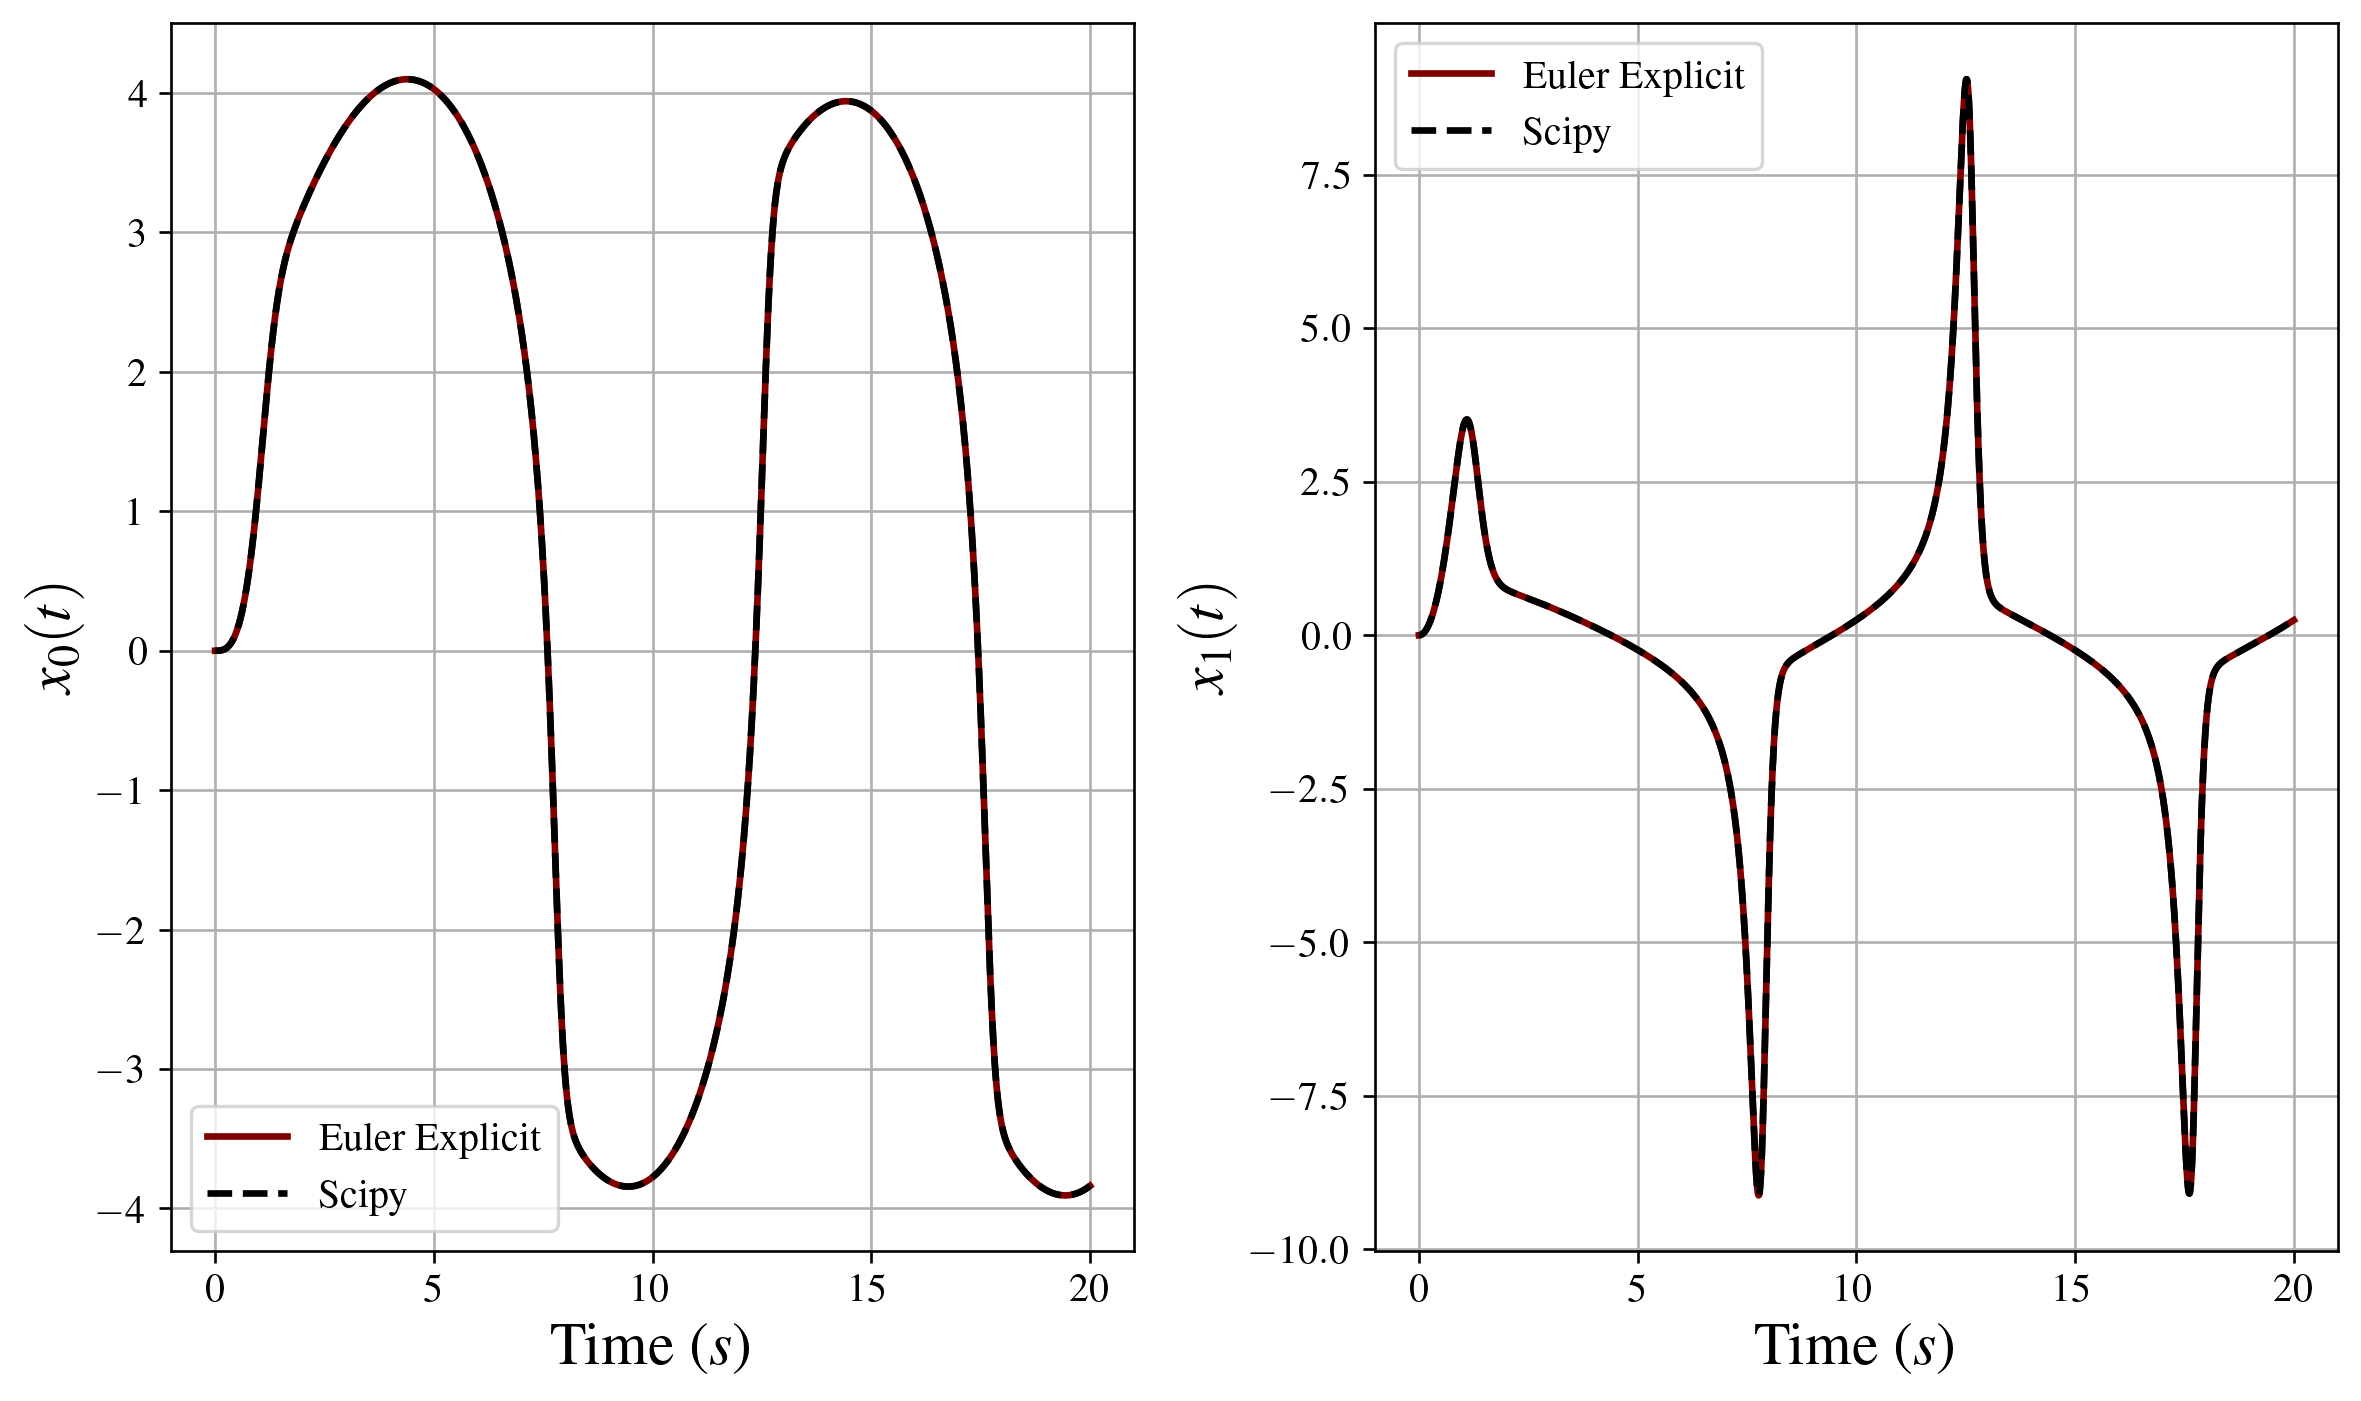

In [7]:
err = 1
del_t = 0.1
t_array, x0_euler, x1_euler, scipy_sol = None, None, None, None
while err > 1e-3:
    del_t /= 2
    t_array = np.arange(0, 20, del_t)
    sol = euler_explicit(state_vars, [0, 0], t_array)
    scipy_sol = odeint(state_vars, [0, 0], t_array)
    x0_euler, x1_euler = np.array(sol[0]), np.array(sol[1])
    err = np.max(np.abs(x0_euler - scipy_sol[:, 0]))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t_array, x0_euler, label='Euler Explicit')
ax[0].plot(t_array, scipy_sol[:, 0], label='Scipy', ls='--')
ax[1].plot(t_array, x1_euler, label='Euler Explicit')
ax[1].plot(t_array, scipy_sol[:, 1], label='Scipy', ls='--')
ax[0].set_ylabel('$x_0(t)$')
ax[1].set_ylabel('$x_1(t)$')
ax[0].set_xlabel('Time ($s$)')
ax[1].set_xlabel('Time ($s$)')
ax[0].legend()
ax[1].legend()
plt.show()

In [8]:
del_t_euler = del_t
del_t_euler # resulting time step used above

2.44140625e-05

### Part C
Similarly to Part B, here is the routine for the fourth order Runge-Kutta method.

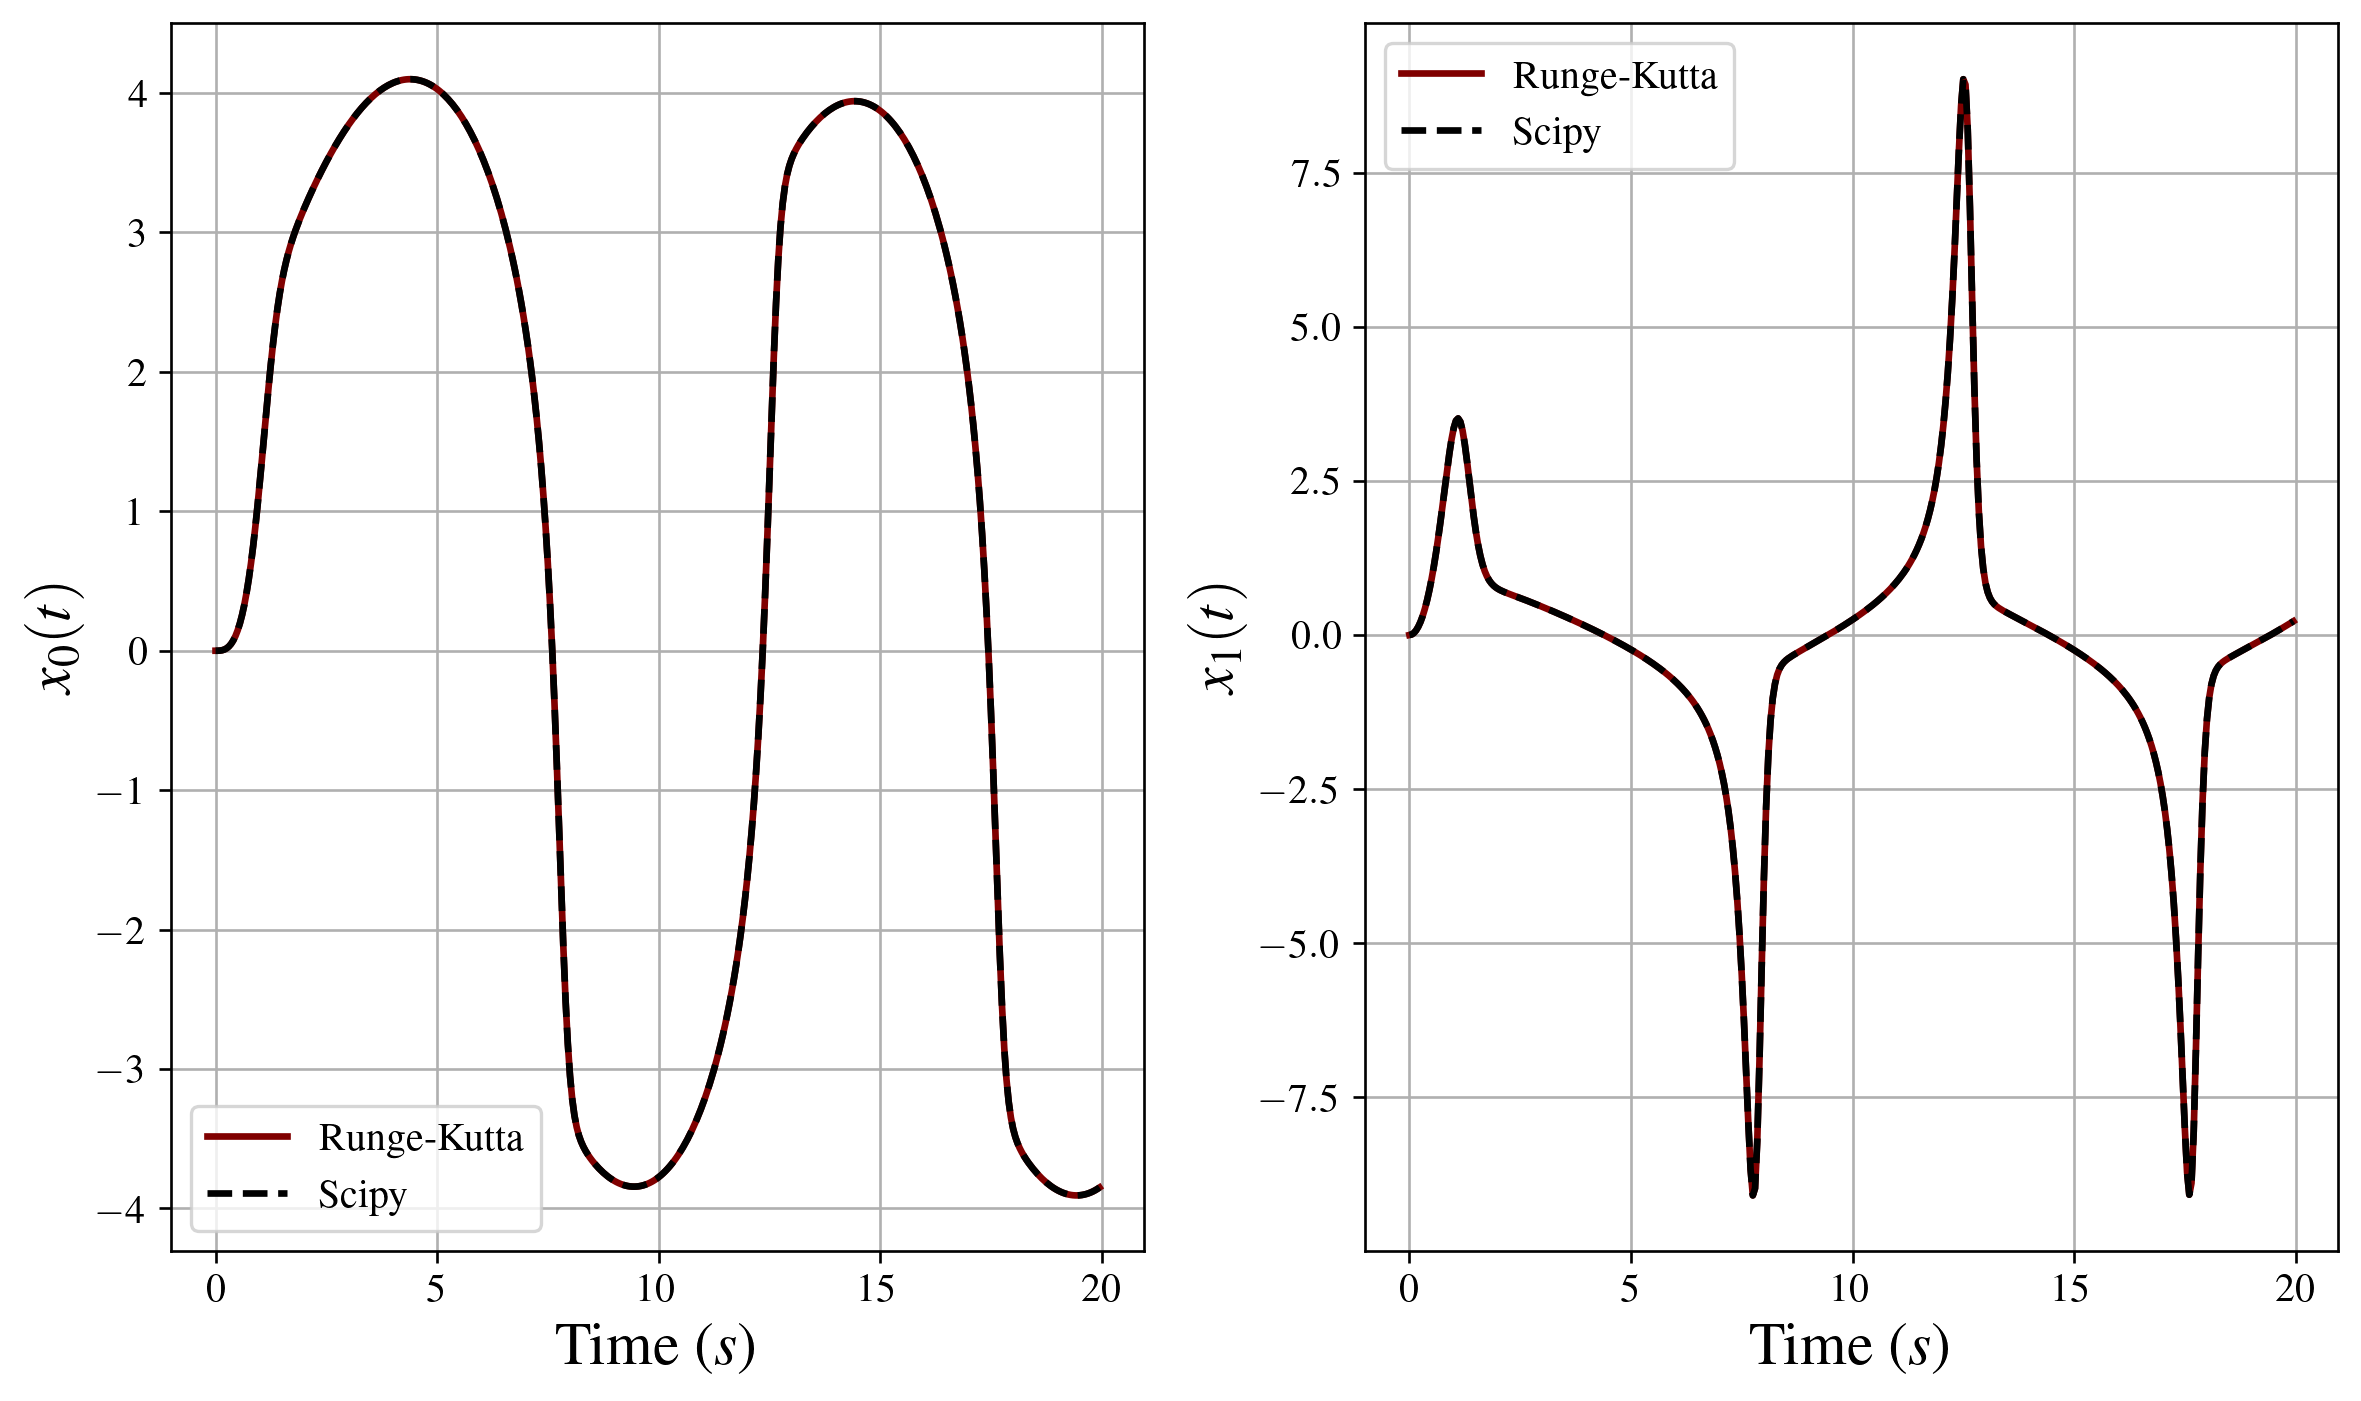

In [9]:
def runge_kutta(func: Callable, y0: List | Iterable, t_values: List | Iterable) -> List:
    n = len(func(y0, t_values[0]))
    arrays = [[y0_] for y0_ in y0]

    for i in range(len(t_values) - 1):
        h = t_values[i + 1] - t_values[i]
        K1 = func([array[i] for array in arrays], t_values[i])
        K2 = func([array[i] + 0.5*h*K for array, K in zip(arrays, K1)], t_values[i] + 0.5*h)
        K3 = func([array[i] + 0.5*h*K for array, K in zip(arrays, K2)], t_values[i] + 0.5*h)
        K4 = func([array[i] + h*K for array, K in zip(arrays, K3)], t_values[i] + h)

        for j in range(n):
            arrays[j].append(arrays[j][i] + h/6*(K1[j] + 2*K2[j] + 2*K3[j] + K4[j]))

    return arrays

err = 1
del_t = 0.1
t_array, x0_rk, x1_rk = None, None, None
while err > 1e-3:
    del_t /= 2
    t_array = np.arange(0, 20, del_t)
    sol = runge_kutta(state_vars, [0, 0], t_array)
    scipy_sol = odeint(state_vars, [0, 0], t_array)
    x0_rk, x1_rk = np.array(sol[0]), np.array(sol[1])
    err = np.max(np.abs(x0_rk - scipy_sol[:, 0]))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t_array, x0_rk, label='Runge-Kutta')
ax[0].plot(t_array, scipy_sol[:, 0], label='Scipy', ls='--')
ax[1].plot(t_array, x1_rk, label='Runge-Kutta')
ax[1].plot(t_array, scipy_sol[:, 1], label='Scipy', ls='--')
ax[0].set_ylabel('$x_0(t)$')
ax[1].set_ylabel('$x_1(t)$')
ax[0].set_xlabel('Time ($s$)')
ax[1].set_xlabel('Time ($s$)')
ax[0].legend()
ax[1].legend()
plt.show()

In [10]:
del_t_rk = del_t
del_t_rk # resulting time step used above

0.05

### Part D
As you can see above, with the convergence criteria, the Euler Explicit method converges at a time step of $2.44140625\cdot10^{-5}$, and the Runge-Kutta method converges at a time step of $0.5$. The Runge-Kutta method, however, has four times more computations for each time step, but has far fewer time steps to converge.

In [11]:
euler_array_size = np.arange(0, 20, del_t_euler).size
rk_array_size = np.arange(0, 20, del_t_rk).size
euler_array_size, rk_array_size

(819200, 400)

The above output shows that the Euler Explicit array has a size of 819200, while the Runge-Kutta has a size of 400. Even with the four extra computations per time step, the Runge-Kutta method is more computationally efficient because $4\cdot400=1600<<819200$.

## Verification
The above problems show that the `scipy` solver agrees with the Euler Explicit and Runge-Kutta methods. We can further verify that this solution is correct by testing the original differential equation. We can plug each solution into the original equation and see if the error is close to zero.

In [12]:
x0, x1 = scipy_sol[:, 0], scipy_sol[:, 1]
x1_dot = np.gradient(x1, t_array, edge_order=2)
err = x1_dot - mu_*(1 - x0**2)*x1 + x0 - A_*np.sin(omega_*t_array)
np.mean(err)

-0.0001447673813758238

The above cell finds the mean error for each time step and shows that the error is very close to zero.

# Problem 2
![Figure 1](fig1.png)

The above image shows thrust/speed and drag force on a 4000 lbs boat. The thrust is based on the throttle position.